In [4]:
import theano
import lasagne
import numpy as np
from theano import tensor as T
%pylab inline

ImportError: cannot import name nonlinearities

In [3]:
import os
import gzip
import numpy as np
from scipy import io
import cPickle as pickle

import os
import gzip
import numpy as np
from scipy import io
import cPickle as pickle


def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


def load_mnist(base='./data/mnist'):

    """
    load_mnist taken from https://github.com/Lasagne/Lasagne/blob/master/examples/images.py
    :param base: base path to images dataset
    """

    def load_mnist_images(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 1, 28, 28)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        return data

    # We can now download and read the training and test set image and labels.
    X_train = load_mnist_images(base + '/train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels(base + '/train-labels-idx1-ubyte.gz')

    return X_train, y_train, (None, 1, 28, 28)

In [5]:
import os
import gzip
import numpy as np
from scipy import io
import cPickle as pickle

X_train, y_train, shape = load_mnist()

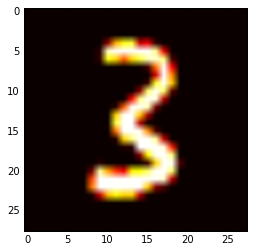

In [9]:
pylab.imshow(X_train[50000, 0], cmap=pylab.cm.hot)

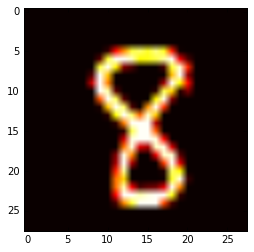

In [19]:
pylab.imshow(X_train[50001, 0],cmap=pylab.cm.hot)

In [20]:
?pylab.cm.hot

In [10]:
input_x, target_x = T.tensor4("Input value",  dtype='float32'), T.tensor4("Target value", dtype='float32')

In [35]:
?lasagne.layers

In [43]:

# Тут вам нужно собрать автоэнкодер, за вас написаны первый и последний слой,
# Нужно приделать к нему один или несколько средних

net = lasagne.layers.InputLayer((None, 1, 28, 28), input_x, name='Input') # Входной слой
mid = lasagne.layers.DenseLayer(net, num_units=10)
net = lasagne.layers.DenseLayer(net, 28*28) # Последний слой
net = lasagne.layers.ReshapeLayer(net, [[0], 1, 28, 28])

In [37]:
predict_train = lasagne.layers.get_output(net)
loss_train = lasagne.objectives.squared_error(predict_train, target_x).mean()

In [38]:
weights = lasagne.layers.get_all_params(net, trainable=True)
updates = lasagne.updates.adam(loss_train, weights, learning_rate=1e-4)

In [39]:
train_func = theano.function([input_x, target_x], [loss_train], updates=updates, allow_input_downcast=True)
predi_func = theano.function([input_x], [predict_train], allow_input_downcast=True)
mid_func = theano.function([input_x], [lasagne.layers.get_output(mid)], allow_input_downcast=True)

In [44]:
for i in range(10):
    loss, num_pass = 0, 0
    for (inputs, targets) in iterate_minibatches(X_train, X_train, 100, shuffle=True):
        loss += train_func(inputs, targets)[0]
        num_pass += 1  
    print 'epoch:', i, 'loss = ', loss/num_pass, 'ok' if loss/num_pass < 0.05 else 'need to add more layers'

epoch: 0 loss =  0.00347742714935 ok
epoch: 1 loss =  0.00311420023743 ok
epoch: 2 loss =  0.00278568017237 ok
epoch: 3 loss =  0.00252153459407 ok
epoch: 4 loss =  0.00229059828874 ok
epoch: 5 loss =  0.00209414721238 ok
epoch: 6 loss =  0.00192717696555 ok
epoch: 7 loss =  0.00178250492498 ok
epoch: 8 loss =  0.00164944309211 ok
epoch: 9 loss =  0.00153831344745 ok


TypeError: ('Bad input argument to theano function with name "<ipython-input-65-7ca8b42f0c08>:9" at index 0 (0-based)', 'Wrong number of dimensions: expected 2, got 4 with shape (1L, 1L, 28L, 28L).')

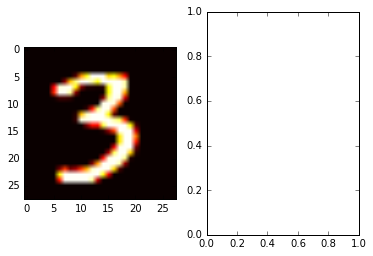

In [71]:
pylab.subplot(121)
pylab.imshow(X_train[10000, 0], cmap=pylab.cm.hot)
pylab.subplot(122)
pylab.imshow(predi_func(X_train[10000, 0].reshape(1, 1, 28, 28))[0][0][0], cmap=pylab.cm.hot)

In [29]:
from sklearn.manifold import TSNE

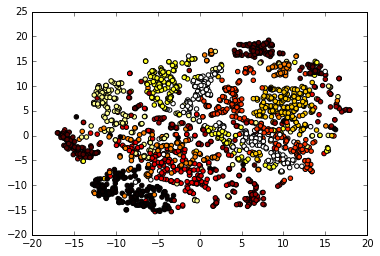

In [42]:
X_mid = mid_func(X_train)[0]
X_tsne = TSNE(n_components=2, n_iter=200).fit_transform(X_mid[:2000])
pylab.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train[:2000], cmap=pylab.cm.hot)

In [45]:
X_train_mid, y_train, X_test_mid = np.load('X_train_mid.npy'), X_train, np.load('X_test_mid.npy')

In [75]:
input_x, target_x = T.matrix("Input value",  dtype='float32'), T.tensor4("Target value", dtype='float32')
mid = lasagne.layers.InputLayer((None, 20), input_x, name='Input')
mid2 = lasagne.layers.DenseLayer(mid,num_units=100)
mid3 = lasagne.layers.DenseLayer(mid2,num_units=500)
net = lasagne.layers.DenseLayer(mid3,28*28)
net = lasagne.layers.ReshapeLayer(net, [[0], 1, 28, 28])

In [76]:
# Получим предсказания от сети и определим функцию хорошести предсказания, как l2 норму
predict_train = lasagne.layers.get_output(net)
loss_train = lasagne.objectives.squared_error(predict_train, target_x).mean()
# Получим градиенты для обучения
weights = lasagne.layers.get_all_params(net, trainable=True)
updates = lasagne.updates.adam(loss_train, weights, learning_rate=1e-4)
# Скомпилируем теано граф
train_func = theano.function([input_x, target_x], [loss_train], updates=updates, allow_input_downcast=True)
predi_func = theano.function([input_x], [predict_train], allow_input_downcast=True)
mid_func = theano.function([input_x], [lasagne.layers.get_output(mid)], allow_input_downcast=True)

In [77]:
for i in range(5):
    loss, num_pass = 0, 0
    for (inputs, targets) in iterate_minibatches(X_train_mid, X_train, 100, shuffle=True):
        loss += train_func(inputs, targets)[0]
        num_pass += 1  
    print 'epoch:', i, 'loss = ', loss/num_pass

epoch: 0 loss =  0.0624791228476
epoch: 1 loss =  0.040194304221
epoch: 2 loss =  0.0382249689267
epoch: 3 loss =  0.0371439012869
epoch: 4 loss =  0.0361562469207


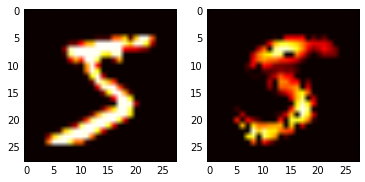

In [78]:
pylab.subplot(121)
pylab.imshow(X_train[0, 0], cmap=pylab.cm.hot)
pylab.subplot(122)
pylab.imshow(predi_func(X_train_mid[0].reshape(1, 20))[0][0][0], cmap=pylab.cm.hot)

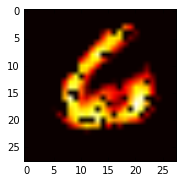

In [89]:
pylab.subplot(122)
pylab.imshow(predi_func(X_test_mid[9999].reshape(1, 20))[0][0][0], cmap=pylab.cm.hot)